Paper 3 - https://arxiv.org/pdf/1805.00794.pdf

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import cv2

In [3]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d shayanfazeli/heartbeat

 98% 97.0M/98.8M [00:02<00:00, 36.3MB/s]
100% 98.8M/98.8M [00:02<00:00, 50.1MB/s]


In [5]:
import zipfile
zf = "/content/heartbeat.zip"
target_dir = "/content/dataset/mitbih-database"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils import resample
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, MaxPool1D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random

In [7]:
train = pd.read_csv('/content/dataset/mitbih-database/mitbih_train.csv',header=None)
test = pd.read_csv('/content/dataset/mitbih-database/mitbih_test.csv',header=None)

In [8]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,0.052632,0.140351,0.119298,0.091228,0.140351,0.161404,0.105263,0.143860,0.143860,0.129825,0.147368,0.157895,0.164912,0.168421,0.154386,0.175439,0.164912,0.154386,0.182456,0.192982,0.196491,0.207018,0.217544,0.217544,0.256140,0.284211,0.294737,0.301754,0.301754,0.322807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,0.078333,0.183333,0.275000,0.315000,0.361667,0.430000,0.481667,0.526667,0.543333,0.563333,0.581667,0.588333,0.600000,0.603333,0.613333,0.6216

In [9]:
train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,0.198778,0.203550,0.208776,0.212885,0.218393,0.224966,0.231377,0.237123,0.242582,0.247923,0.253749,0.259748,0.266244,0.272734,0.279355,0.285588,0.291808,0.297672,0.303384,0.308795,0.313890,0.318454,0.322087,0.324891,0.326737,0.327817,0.327931,0.326746,0.324326,0.320537,...,0.030729,0.029582,0.028531,0.027573,0.026875,0.025771,0.024823,0.023932,0.023060,0.022458,0.021809,0.021245,0.020623,0.020026,0.019534,0.019053,0.018592,0.017664,0.016740,0.015722,0.014402,0.013024,0.011625,0.010262,0.008929,0.008056,0.007278,0.006531,0.005981,0.005479,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,0.171796,0.176496,0.180274,0.184101,0.186963,0.190002,0.193899,0.198465,0.202855,0.207166,0.211187,0.214821,0.218450,0.221486,0.224031,0.225848,0.227133,0.227830,0.228436,0.228871,0.228760,0.228393,0.227472,0.226180,0.224659,0.223110,0.221352,0.219258,0.216884,0.214168,...,0.116516,0.114463,0.112686,0.111103,0.110513,0.108566,0.106493,0.104591,0.102658,0.101395,0.100201,0.099386,0.098327,0.096635,0.095729,0.095368,0.095055,0.092902,0.091118,0.088574,0.084638,0.079949,0.075307,0.069892,0.063994,0.060074,0.056404,0.052840,0.050006,0.046693,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,0.070543,0.069182,0.068293,0.067744,0.070175,0.072993,0.074803,0.075972,0.076923,0.077872,0.079442,0.081911,0.085938,0.090032,0.094595,0.098901,0.103960,0.109348,0.114754,0.120730,0.127946,0.135962,0.144295,0.151852,0.157895,0.161035,0.161133,0.159383,0.157343,0.155388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Count in each label: 
0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


<BarContainer object of 5 artists>

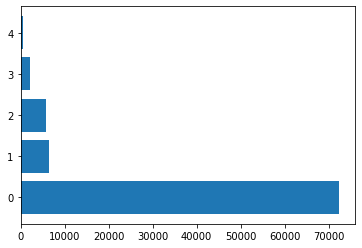

In [10]:
# The classes

label_names = ['Non-ecotic beats (normal beat)', 'Supraventricular ectopic beats', 'Ventricular ectopic beats', 'Fusion beats', 'Unknown beats']

labels = train[187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

plt.barh(list(set(labels)), list(labels.value_counts()))

In [11]:
# Separating the train dataframe into 5 individual ones based on class labels, and sampling 50000 from each.

train_lbl0 = resample(train[train[187]==0], replace=True, n_samples=50000, random_state=113)
train_lbl1 = resample(train[train[187]==1], replace=True, n_samples=50000, random_state=113)
train_lbl2 = resample(train[train[187]==2], replace=True, n_samples=50000, random_state=113)
train_lbl3 = resample(train[train[187]==3], replace=True, n_samples=50000, random_state=113)
train_lbl4 = resample(train[train[187]==4], replace=True, n_samples=50000, random_state=113)

In [12]:
# Concatenate the 5 dataframes into 1

train = pd.concat([train_lbl0, train_lbl1, train_lbl2, train_lbl3, train_lbl4])

labels = train[187].astype('int64')   # last column has the labels

print("Count in each label: ")
print(labels.value_counts())

Count in each label: 
4    50000
3    50000
2    50000
1    50000
0    50000
Name: 187, dtype: int64


Text(0.5, 1.0, 'Non-ecotic beats (normal beat)')

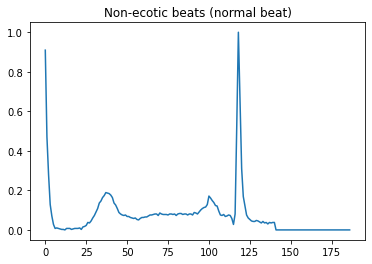

In [13]:
plt.plot(np.array(train_lbl0.sample(1))[0, :187])
plt.title(label_names[0])


Text(0.5, 1.0, 'Supraventricular ectopic beats')

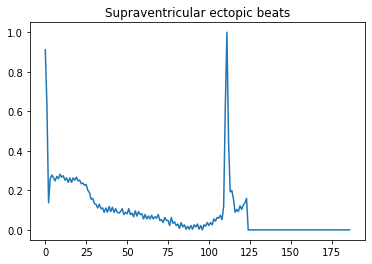

In [14]:
plt.plot(np.array(train_lbl1.sample(1))[0, :187])
plt.title(label_names[1])

Text(0.5, 1.0, 'Ventricular ectopic beats')

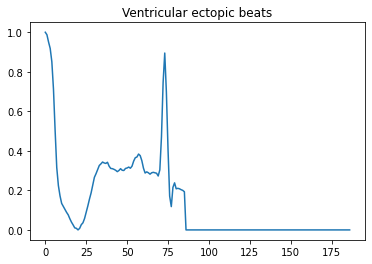

In [15]:
plt.plot(np.array(train_lbl2.sample(1))[0, :187])
plt.title(label_names[2])

Text(0.5, 1.0, 'Fusion beats')

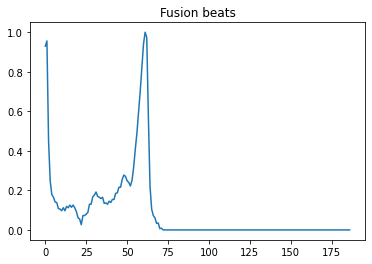

In [16]:
plt.plot(np.array(train_lbl3.sample(1))[0, :187])
plt.title(label_names[3])

Text(0.5, 1.0, 'Unknown beats')

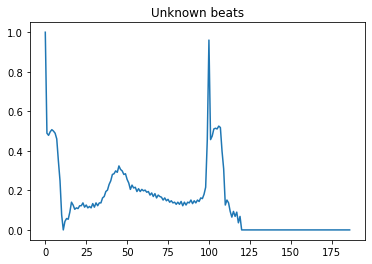

In [17]:
plt.plot(np.array(train_lbl4.sample(1))[0, :187])
plt.title(label_names[4])

In [18]:
# Adding some noise to increase efficiency of the trained model

def gaussian_noise(signal):
    noise = np.random.normal(0,0.05,187)
    return signal + noise

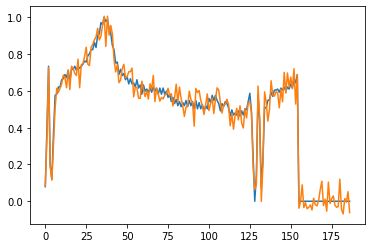

In [19]:
# Visualization with added noise

sample = train_lbl0.sample(1).values[0]

sample_with_noise = gaussian_noise(sample[:187])

plt.subplot(1, 1, 1)

plt.plot(sample[:187])
plt.plot(sample_with_noise)

In [20]:
# One hot encoding the output of the model

ytrain = keras.utils.to_categorical(train[187])
ytest = keras.utils.to_categorical(test[187])

# Input to the model
xtrain = train.values[:, :187]
xtest = test.values[:, :187]

# Adding noise
for i in range(xtrain.shape[0]):
    xtrain[i, :187] = gaussian_noise(xtrain[i, :187])

In [21]:
# Viewing the shapes

xtrain = np.expand_dims(xtrain, 2)
xtest = np.expand_dims(xtest, 2)

print("Shape of training data: ")
print("Input: ", xtrain.shape)
print("Output: ", ytrain.shape)

print("\nShape of test data: ")
print("Input: ", xtest.shape)
print("Output: ", ytest.shape)

Shape of training data: 
Input:  (250000, 187, 1)
Output:  (250000, 5)

Shape of test data: 
Input:  (21892, 187, 1)
Output:  (21892, 5)


In [22]:
xtrain[0].shape

(187, 1)

In [23]:
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, Add, ReLU
from sklearn.metrics import f1_score, accuracy_score

In [41]:
def get_model():
    nclass = 5
    
    inp = Input(shape=xtrain[0].shape)
    conv = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="same")(inp)
    print(inp)
    print(conv)

    img_1 = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="same")(conv)
    img_1 = Convolution1D(32, kernel_size=5, activation=None, padding="same")(img_1)
    add = Add()([conv,img_1])
    act = ReLU()(add)
    pooling_1 = MaxPool1D(pool_size=5,strides=2)(act)

    img_2 = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="same")(pooling_1)
    img_2 = Convolution1D(32, kernel_size=5, activation=None, padding="same")(img_2)
    add_2 = Add()([pooling_1,img_2])
    act_2 = ReLU()(add_2)
    pooling_2 = MaxPool1D(pool_size=5,strides=2)(act_2)

    img_3 = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="same")(pooling_2)
    img_3 = Convolution1D(32, kernel_size=5, activation=None, padding="same")(img_3)
    add_3 = Add()([pooling_2,img_3])
    act_3 = ReLU()(add_3)
    pooling_3 = MaxPool1D(pool_size=5,strides=2)(act_3)

    img_4 = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="same")(pooling_3)
    img_4 = Convolution1D(32, kernel_size=5, activation=None, padding="same")(img_4)
    add_4 = Add()([pooling_3,img_4])
    act_4 = ReLU()(add_4)
    pooling_4 = MaxPool1D(pool_size=5,strides=2)(act_4)

    img_5 = Convolution1D(32, kernel_size=5, activation=activations.relu, padding="same")(pooling_4)
    img_5 = Convolution1D(32, kernel_size=5, activation=None, padding="same")(img_5)
    add_5 = Add()([pooling_4,img_5])
    act_5 = ReLU()(add_5)
    pooling_5 = MaxPool1D(pool_size=5,strides=2)(act_5)

    fl = Flatten()(pooling_5)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(fl)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [42]:
model = get_model()

KerasTensor(type_spec=TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name='input_8'), name='input_8', description="created by layer 'input_8'")
KerasTensor(type_spec=TensorSpec(shape=(None, 187, 32), dtype=tf.float32, name=None), name='conv1d_35/Relu:0', description="created by layer 'conv1d_35'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 187, 32)      192         input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 187, 32)      5152        conv1d_35[0][0]      

In [43]:
xtrain.shape, ytrain.shape

((250000, 187, 1), (250000, 5))

In [44]:
history = model.fit(xtrain, ytrain, epochs = 25, batch_size = 32, validation_data = (xtest, ytest))

Epoch 1/25
7813/7813 [==============================] - 59s 5ms/step - loss: 0.3613 - acc: 0.8645 - val_loss: 0.2153 - val_acc: 0.9164
Epoch 2/25
7813/7813 [==============================] - 41s 5ms/step - loss: 0.1281 - acc: 0.9535 - val_loss: 0.1630 - val_acc: 0.9394
Epoch 3/25
7813/7813 [==============================] - 41s 5ms/step - loss: 0.1017 - acc: 0.9629 - val_loss: 0.1591 - val_acc: 0.9406
Epoch 4/25
7813/7813 [==============================] - 41s 5ms/step - loss: 0.0854 - acc: 0.9694 - val_loss: 0.1240 - val_acc: 0.9584
Epoch 5/25
7813/7813 [==============================] - 41s 5ms/step - loss: 0.0812 - acc: 0.9712 - val_loss: 0.1186 - val_acc: 0.9604
Epoch 6/25
7813/7813 [==============================] - 41s 5ms/step - loss: 0.0758 - acc: 0.9732 - val_loss: 0.1351 - val_acc: 0.9555
Epoch 7/25
7813/7813 [==============================] - 41s 5ms/step - loss: 0.0709 - acc: 0.9753 - val_loss: 0.1939 - val_acc: 0.9263
Epoch 8/25
7813/7813 [==============================] -

In [45]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.legend([variable, variable2])
    plt.title(variable)

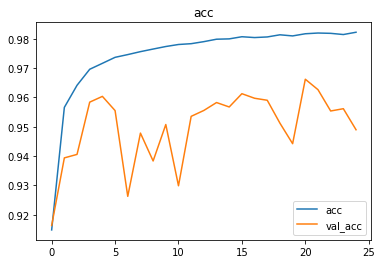

In [46]:
plot(history.history, "acc", "val_acc")

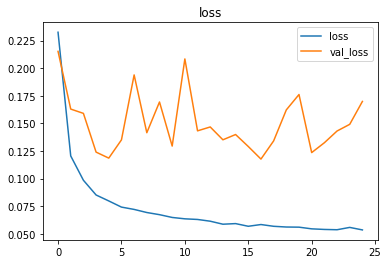

In [47]:
plot(history.history, "loss", "val_loss")

Actual label:  Non-ecotic beats (normal beat)
Model prediction :  Fusion beats  with probability  0.66421545


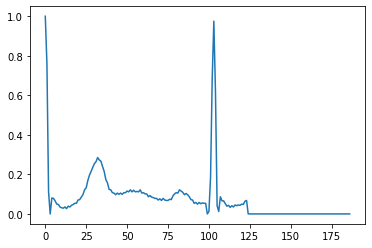

In [48]:
i = random.randint(0, len(xtest)-1)

output = model(np.expand_dims(xtest[i], 0))

pred = output.numpy()[0]

plt.plot(xtest[0])

print("Actual label: ", label_names[np.argmax(ytest[i])])
print("Model prediction : ", label_names[np.argmax(pred)], " with probability ", pred[np.argmax(pred)])

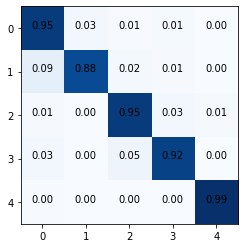

In [49]:
ypred = model.predict(xtest)

cm = confusion_matrix(ytest.argmax(axis=1), ypred.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")


plt.imshow(cm, cmap=plt.cm.Blues)

In [50]:
# Test data class labels spread

print("The distribution of test set labels")
print(test[187].value_counts())

print('F1_score = ', f1_score(ytest.argmax(axis=1), ypred.argmax(axis=1), average = 'macro'))

The distribution of test set labels
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64
F1_score =  0.7953443415660594


In [51]:
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score, log_loss

##accuracy
print("Accuracy: ",accuracy_score(ytest.argmax(axis=1), ypred.argmax(axis=1)))

Accuracy:  0.9489767951763202
